## Auto-Encoder using VGG16 Transfer Learning 
Tyler Lewis

May 2024

In [87]:
from keras.layers import Conv2D, UpSampling2D, Input, Lambda, MaxPool2D, Reshape
from keras.models import Sequential, Model
from keras.losses import MeanSquaredError
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from PIL import Image
import cv2
from skimage.color import rgb2lab, lab2rgb, gray2rgb
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# from skimage.transform import resize
# from skimage.io import imsave
# import keras
# import os


#Local
from src.preprocessing import dataset

In [88]:
# HYPERPARAMETERS

TRAIN_EPOCHS: int = 15
LEARNING_RATE = 0.001
IMAGE_SHAPE: tuple = (360,640)
BATCH_SIZE: int = 32

In [89]:
# Define helper functions

def combine_l_ab(l: np.array, ab: np.array) -> np.array:
    ab = ab*128
    cur = np.zeros((IMAGE_SHAPE + (3,)))
    
    if len(l.shape) == 2:
        cur[:,:,0] = l
    elif len(l.shape) == 3:
        cur[:,:,0] = l[:, :, 0]
    else:
        print('error in combining lab img')
    cur[:,:,1:] = ab

    return cur

def display_img(img, gray = False): 
    cmap = 'gray' if gray else None
    plt.imshow(img, cmap=cmap) 
    plt.axis('off')  # Hide the axis
    plt.show()

def resize_image(image, target_size):
    height, width = image.shape[:2]
    aspect_ratio = width / height

    if aspect_ratio > 1:
        new_width = target_size[1]
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = target_size[0]
        new_width = int(new_height * aspect_ratio)

    resized_image = cv2.resize(image, (new_width, new_height))
    return resized_image


In [90]:
'''
MODEL ARCHITECTURE
'''
#
# Define encoder
#
encoder_input_shape = (IMAGE_SHAPE + (3,)) # Add color dim to input shape
encoder: Model = VGG16(include_top=False, weights='imagenet', input_shape=encoder_input_shape)

# Freeze the pretrained layers
# The whole reason we are using VGG16
for layer in encoder.layers:
    layer.trainable = False

# Access the output shape of the encoder
encoder_output_shape = encoder.output_shape[1:] # Drop batch size element
print('VGG16-based encoder output shape: ' + str(encoder_output_shape))

# Display summary of encoder model
# encoder.summary()

#
# Define decoder
#
decoder = Sequential(
    [
        Input(shape=encoder_output_shape),
        Conv2D(256, (3,3), activation='relu', padding='same'),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(16, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(2, (3, 3), activation='tanh', padding='same'),
        UpSampling2D((2, 2)),
        Lambda(lambda x: tf.image.resize(x, IMAGE_SHAPE, method=tf.image.ResizeMethod.BILINEAR))
    ],
    name='ColorizationDecoder'
)

# Access the output shape of the decoder
decoder_output_shape = decoder.output_shape[1:] # Drop batch size element
print('Decoder output shape: ' + str(decoder_output_shape))

# decoder.summary()

VGG16-based encoder output shape: (11, 20, 512)
Decoder output shape: (360, 640, 2)


In [91]:
'''
DATA GENERATOR
'''
# Helps to decrease memory usage
def data_generator(batch_size, df):
    num_samples = len(df)
    indices = np.arange(num_samples)

    while True:
        # Shuffle the indices for each epoch
        np.random.shuffle(indices)
        
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_df = df.iloc[batch_indices]
            batch_gray_images = []
            batch_encoder_features = []
            batch_ab_channels = []
            
            for index, row in batch_df.iterrows():
                # Load gray image 
                gray_image = np.array(Image.open(row['gray']))
                resized_gray_image = resize_image(gray_image, IMAGE_SHAPE)
                resized_gray_image_rgb = np.stack((resized_gray_image,) * 3, axis=-1) # Convert gray image to RGB format

                # Load rgb validation image
                rgb_image = np.array(Image.open(row['rgb']))
                resized_rgb_image = resize_image(rgb_image, IMAGE_SHAPE)
                lab_image = rgb2lab(resized_rgb_image) # Convert RGB image to LAB color space
                ab_channels = lab_image[:, :, 1:] # Extract only the AB channels

                batch_gray_images.append(resized_gray_image_rgb)
                batch_ab_channels.append(ab_channels)

            # Generate encoder features for the batch
            batch_encoder_features = encoder.predict(np.array(batch_gray_images), verbose=0)

            # Reshape encoder features to the expected shape
            batch_encoder_features = [feature.reshape(encoder_output_shape) for feature in batch_encoder_features]

            yield np.array(batch_encoder_features), np.array(batch_ab_channels)


(360, 640, 3)


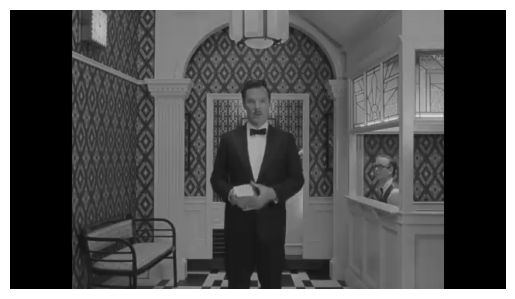

(360, 640, 3)


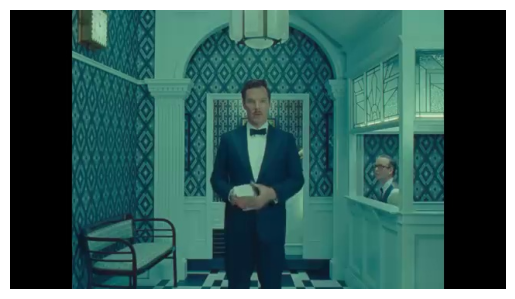

In [92]:
data_dir = 'vibrant'
image_paths_df = dataset(data_dir, image_location='data/')
index = 100

gray_image = np.array(Image.open(image_paths_df.iloc[index]['gray']))
resized_gray_image = resize_image(gray_image, IMAGE_SHAPE)
resized_gray_image_rgb = np.stack((resized_gray_image,) * 3, axis=-1) # Convert gray image to RGB format
print(resized_gray_image_rgb.shape)
display_img(resized_gray_image_rgb)

rgb_image = np.array(Image.open(image_paths_df.iloc[index]['rgb']))
resized_rgb_image = resize_image(rgb_image, IMAGE_SHAPE)
print(resized_rgb_image.shape)
display_img(resized_rgb_image)

In [93]:
data_dir = 'vibrant'
image_paths_df = dataset(data_dir, image_location='data/')
steps_per_epoch = len(image_paths_df) // BATCH_SIZE
# Establish generator
datagenerator = data_generator(BATCH_SIZE, image_paths_df)

optimizer = Adam(learning_rate=LEARNING_RATE)
loss_fn = MeanSquaredError()


decoder.compile(optimizer=optimizer, loss=loss_fn , metrics=['accuracy'])
history = decoder.fit(
    datagenerator, 
    verbose=1, 
    steps_per_epoch=steps_per_epoch,
    epochs=TRAIN_EPOCHS, 
    batch_size=BATCH_SIZE
    )
# decoder.save('colorize_autoencoder_VGG16.model')


Epoch 1/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 872s 10s/step - accuracy: 0.5348 - loss: 206.0954
Epoch 2/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 896s 10s/step - accuracy: 0.5449 - loss: 196.4021
Epoch 3/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 890s 10s/step - accuracy: 0.5486 - loss: 202.1601
Epoch 4/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 875s 10s/step - accuracy: 0.5509 - loss: 200.0945
Epoch 5/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 880s 10s/step - accuracy: 0.5402 - loss: 196.3687
Epoch 6/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 833s 9s/step - accuracy: 0.5507 - loss: 202.0951
Epoch 7/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 832s 9s/step - accuracy: 0.5449 - loss: 205.4074
Epoch 8/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 833s 9s/step - accuracy: 0.5473 - loss: 197.9677
Epoch 9/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 833s 9s/step - accuracy: 0.5499 - loss: 200.0470
Epoch 10/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 833s 9s/step - accuracy: 0.5441 - loss: 199.0635
Epoch 11/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 832s 9s/step - accuracy: 0.5554 - loss: 199.0419
Epoch 12/15
91/91 ━━━━━━━━━━━━━━━━━━

In [94]:
decoder.save('colorize_decoder_may7.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


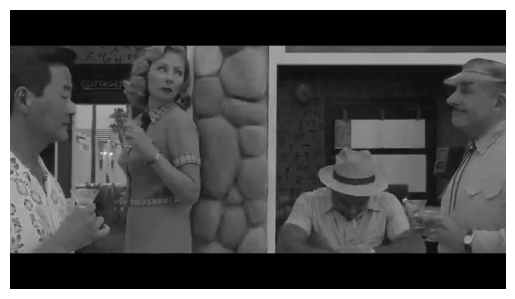

In [95]:
#Predicting using saved model.

import cv2

testpath = 'data/vibrant/rgb/12_rgb_261.jpeg'

testing = np.array(cv2.imread(testpath))

testing_lab = rgb2lab(testing)
l = testing_lab[:,:,0]
l_input = gray2rgb(l).reshape(((1,) + IMAGE_SHAPE + (3,)))
# resized_gray_image_rgb = np.stack((l,) * 3, axis=-1)
# display_img(l, gray=True)

bottleneck = encoder.predict(l_input)

display_img(l, gray=True)


In [96]:
output = decoder.predict(bottleneck)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


In [99]:
print(l.shape)
output[0].shape
print(output)

(360, 640)
[[[[0.99999976 0.99999976]
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]
   ...
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]]

  [[0.99999976 0.99999976]
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]
   ...
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]]

  [[0.99999976 0.99999976]
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]
   ...
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]]

  ...

  [[0.99999976 0.99999976]
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]
   ...
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]]

  [[0.99999976 0.99999976]
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]
   ...
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]]

  [[0.99999976 0.99999976]
   [0.99999976 0.99999976]
   [0.99999976 0.99999976]
   ...
   [0.99999976 0.99999976]
   [0.999999

In [103]:
print(l.shape)
print(output[0].shape)

(360, 640)
(360, 640, 2)


Shape of batch_encoder_features: (32, 11, 20, 512)
Shape of batch_ab_channels: (32, 360, 640, 2)


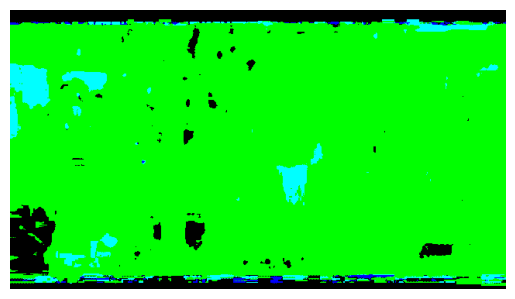

In [106]:
data_dir = 'vibrant'
image_paths_df = dataset(data_dir, image_location='data/')
BATCH_SIZE = 32

# Establish generator
datagenerator = data_generator(BATCH_SIZE, image_paths_df)

# Get a single batch
batch_encoder_features, batch_ab_channels = next(datagenerator)

# Print the shapes of the batch
print("Shape of batch_encoder_features:", batch_encoder_features.shape)
print("Shape of batch_ab_channels:", batch_ab_channels.shape)

ab = batch_ab_channels[0]*128
cur = np.zeros((IMAGE_SHAPE + (3,)))

# if len(l.shape) == 2:
#     cur[:,:,0] = l
# elif len(l.shape) == 3:
#     cur[:,:,0] = l[:, :, 0]
# else:
#     print('error in combining lab img')
cur[:,:,1:] = ab
display_img(cur)

/var/folders/ns/qk2_mvqx6w3bpj6wspgtt2c40000gn/T/ipykernel_89085/612758640.py:4: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 230338 negative Z values that have been clipped to zero
  display_img(lab2rgb(cur))


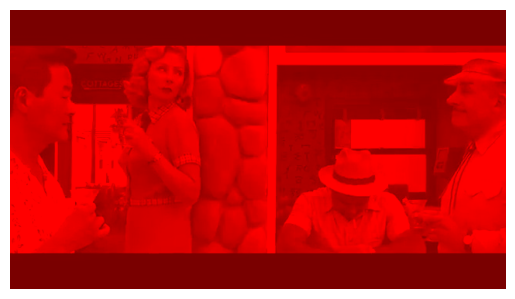

In [108]:
cur = combine_l_ab(l,output[0])
# print(output[0])

display_img(lab2rgb(cur))